# Demo for NeRFFaceEditing

## Define the Settings

Setting up which GPU you are using.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

If you encounter error while building the plugins for StyleGAN2, it may probably be caused by the missing path of ninja. Thus, explicitly adding the path of ninja to the `PATH` environment variable may help.

You can query the path by typing `which ninja` in the conda environment and extract the directory component.

In [2]:
# Uncomment this line if you encounter the error (at least worth a try ;D)
# os.environ['PATH'] = os.environ['PATH'] + ":path-to-ninja(directory only)"

In [4]:
device = "cuda"

## Define the Utility Functions

In [5]:
import cv2
import dnnlib
import torch
import pickle
import mrcfile
import pyshtools
import numpy as np
from PIL import Image
from tqdm import tqdm
from typing import List, Optional, Tuple, Union

import imageio
from torchvision import transforms
from torchvision.utils import make_grid

from matplotlib import pyplot as plt
from camera_utils import LookAtPoseSampler, FOV_to_intrinsics

import warnings
warnings.filterwarnings("ignore")

In [46]:
from IPython.display import clear_output

In [35]:
from torch.nn import functional as F

In [6]:
imageio.plugins.freeimage.download()

In [7]:
@torch.no_grad()
def render_tensor(img: torch.Tensor, normalize: bool = True, nrow: int = 8) -> Image.Image:
    if type(img) == list:
        img = torch.cat(img, dim=0).expand(-1, 3, -1, -1)
    elif len(img.shape) == 3:
        img = img.expand(3, -1, -1)
    elif len(img.shape) == 4:
        img = img.expand(-1, 3, -1, -1)
    
    img = img.squeeze()
    
    if normalize:
        img = img / 2 + .5
    
    if len(img.shape) == 3:
        return Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
    elif len(img.shape) == 2:
        return Image.fromarray((img.cpu().numpy() * 255).astype(np.uint8))
    elif len(img.shape) == 4:
        return Image.fromarray((make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))

In [8]:
@torch.no_grad()
def vis_parsing_maps(im: torch.Tensor, inverse: bool = False, argmax: bool = True):
    part_colors = [
        [0, 0, 0], # Background
        [127, 212, 255], # Skin
        [255, 212, 255], # Eye Brow
        [255, 255, 170], # Eye
        [255, 255, 130], # Glass
        [76, 153, 0], # Ear
        [0, 255, 170], # Ear Ring
        [244, 124, 244], # Nose
        [30, 162, 230], # Mouth
        [127, 255, 255], # Lip
        [127, 170, 255], # Neck
        [85, 0, 255], # Neck-lace
        [255, 170, 127], # Cloth
        [212, 127, 255], # Hair
        [0, 170, 255], # Hat
        [255, 255, 255]
    ]
    if inverse == False:
        if argmax:
            im = torch.argmax(im, dim=1, keepdim=True)
        out = torch.zeros((im.size(0), 3, im.size(2), im.size(3)), device=im.device, dtype=torch.float32)

        for index in range(len(part_colors)):
            color = torch.from_numpy(np.array(part_colors[index])).to(out.device).to(out.dtype).view(1, 3, 1, 1).expand_as(out)
            out = torch.where(im == index, color, out)

        out = out / 255.0 * 2 - 1
        return out
    else:
        out = torch.zeros((im.size(0), 1, im.size(2), im.size(3)), device=im.device, dtype=torch.int64)
        
        for index in range(len(part_colors)):
            color = torch.from_numpy(np.array(part_colors[index])).to(im.device).to(im.dtype).view(1, 3, 1, 1).expand_as(im) / 255.0 * 2 - 1
            out = torch.where(torch.all((im - color).abs() <= 1e-2, dim=1, keepdim=True), torch.ones((im.size(0), 1, im.size(2), im.size(3)), device=out.device, dtype=torch.int64) * index, out)
        
        return out

## Loading the Model

In [9]:
with open("./networks/NeRFFaceEditing-ffhq-64.pkl", "rb") as f:
    G = pickle.load(f)['G_ema'].to(device).eval().requires_grad_(False)
G.rendering_kwargs['depth_resolution'] = 96
G.rendering_kwargs['depth_resolution_importance'] = 96

In [10]:
fov_deg = 18.837
intrinsics = FOV_to_intrinsics(fov_deg, device=device)
cam_pivot = torch.tensor(G.rendering_kwargs.get('avg_camera_pivot', [0, 0, 0]), device=device)
cam_radius = G.rendering_kwargs.get('avg_camera_radius', 2.7)

conditioning_cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
conditioning_params = torch.cat([conditioning_cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

In [11]:
def mapping(G, z: torch.Tensor, conditioning_params: torch.Tensor, truncation_psi=1., truncation_cutoff=14, update_emas=True):
    return G.backbone.mapping(z, conditioning_params, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff, update_emas=update_emas)

In [12]:
def encode(G, ws, **synthesis_kwargs):
    planes = G.backbone.synthesis(ws, **synthesis_kwargs)
    planes = planes.view(len(planes), 3, 32, planes.shape[-2], planes.shape[-1])
    return planes

In [13]:
def decode(G, ws, cam, norm_planes, denorm_planes, **synthesis_kwargs):
    cam2world_matrix = cam[:, :16].view(-1, 4, 4)
    intrinsics = cam[:, 16:25].view(-1, 3, 3)
    neural_rendering_resolution = G.neural_rendering_resolution
    
    # Create a batch of rays for volume rendering
    ray_origins, ray_directions = G.ray_sampler(cam2world_matrix, intrinsics, neural_rendering_resolution)
    N, M, _ = ray_origins.shape
    
    # Perform volume rendering
    feature_samples, seg_samples, depth_samples, weights_samples = \
        G.renderer(norm_planes, denorm_planes, G.decoder, ray_origins, ray_directions, G.rendering_kwargs)
    
    # Reshape into 'raw' neural-rendered image
    H = W = G.neural_rendering_resolution
    feature_image = feature_samples.permute(0, 2, 1).reshape(N, feature_samples.shape[-1], H, W).contiguous()
    seg_image = seg_samples.permute(0, 2, 1).reshape(N, seg_samples.shape[-1], H, W).contiguous()
    depth_image = depth_samples.permute(0, 2, 1).reshape(N, 1, H, W)
    
    # Run superresolution to get final image
    rgb_image = feature_image[:, :3]
    sr_image = G.superresolution(
        rgb_image, 
        feature_image, 
        ws, 
        noise_mode=G.rendering_kwargs['superresolution_noise_mode'], 
        **{k:synthesis_kwargs[k] for k in synthesis_kwargs.keys() if k != 'noise_mode'}
    )
    
    return {
        'image_raw': rgb_image, 
        'image': sr_image, 
        'image_depth': depth_image, 
        'image_seg': seg_image, 
    }

In [14]:
def compute_mean_var(planes):
    # (N, 3, C, H, W)
    mean = torch.mean(planes, dim=(-1, -2), keepdim=True)
    var = torch.sqrt(torch.var(planes, dim=(-1, -2), keepdim=True))
    return mean, var

In [15]:
def normalize_plane(planes):
    mean, var = compute_mean_var(planes)
    planes = (planes - mean) / (var + 1e-8)
    return planes, mean, var

In [16]:
def denormalize_plane(planes, mean, var):
    return planes * var + mean

In [38]:
import lpips
lpips_loss = lpips.LPIPS(net='vgg').to(device)
read_seg = lambda fn: (transforms.ToTensor()(Image.open(fn).convert('RGB')) * 2 - 1).unsqueeze(0).to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/jiangkaiwen/anaconda3/envs/eg3d/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


## Style Transfer

In [26]:
random_state = np.random.RandomState(1)
z = torch.from_numpy(random_state.randn(2, G.z_dim)).to(device)

In [18]:
cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

In [27]:
ws = mapping(G, z, conditioning_params.expand(z.size(0), -1), truncation_psi=.5)
planes = encode(G, ws, noise_mode='const')
norm_planes, means, variances = normalize_plane(planes)
denorm_planes = planes

In [28]:
out_ref = decode(G, ws, camera_params.expand(ws.size(0), -1), norm_planes, denorm_planes, noise_mode='const')
out_style_1 = decode(G, ws, camera_params.expand(ws.size(0), -1), norm_planes, denormalize_plane(norm_planes, means[:1], variances[:1]), noise_mode='const')
out_style_2 = decode(G, ws, camera_params.expand(ws.size(0), -1), norm_planes, denormalize_plane(norm_planes, means[1:], variances[1:]), noise_mode='const')

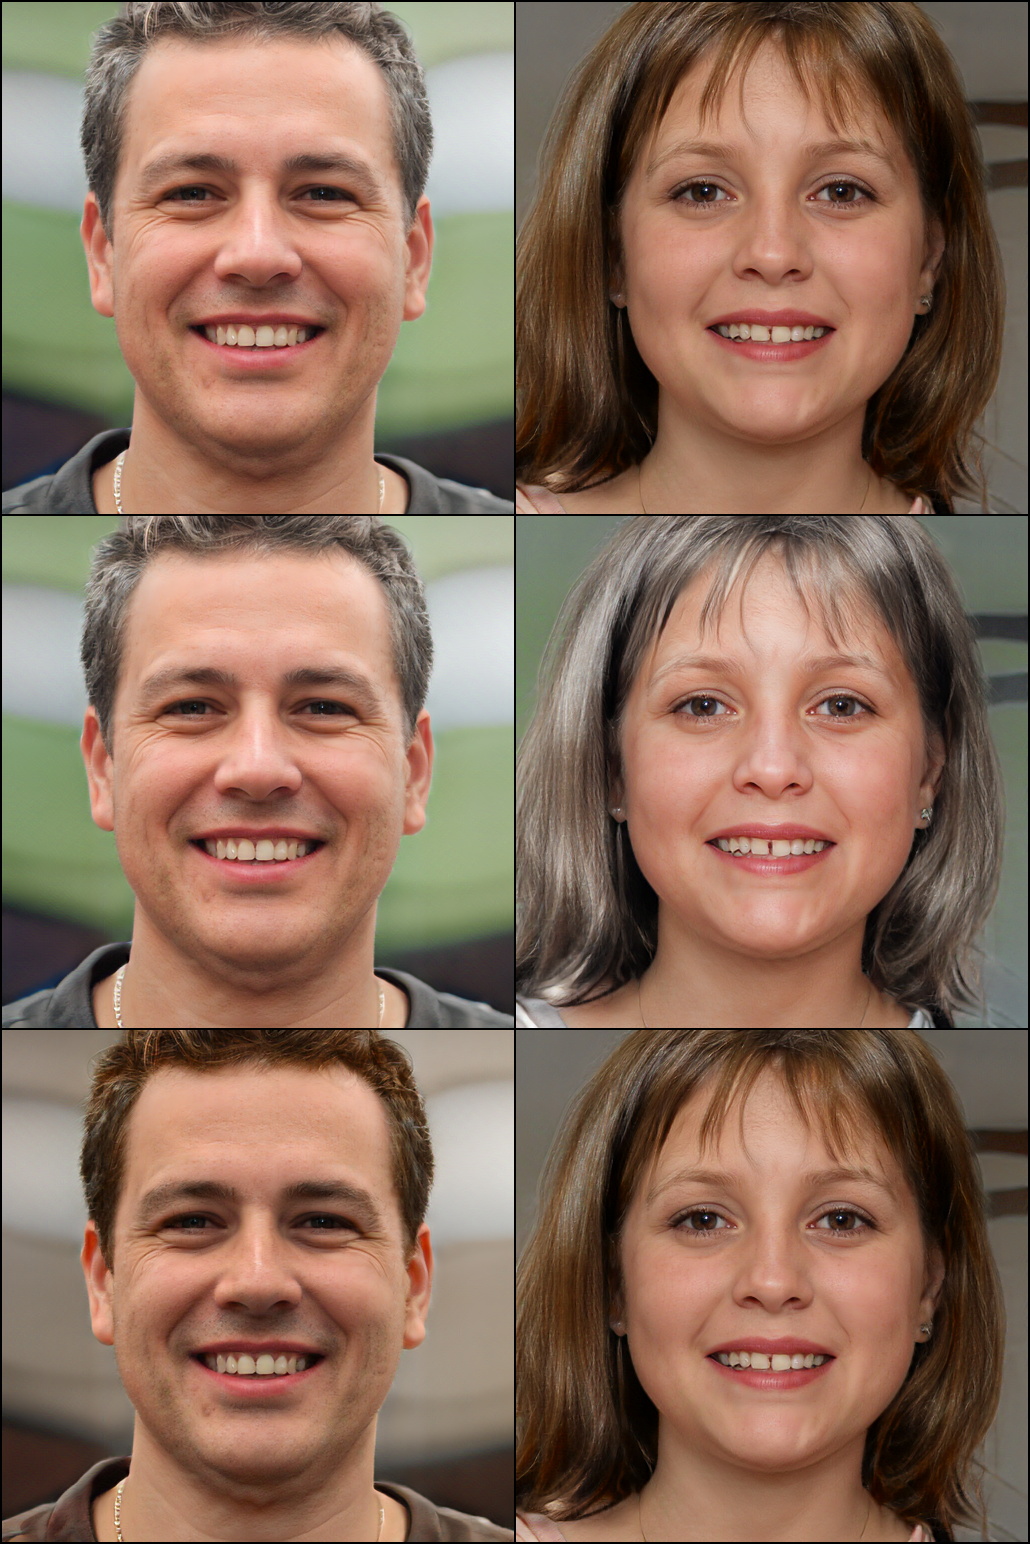

In [29]:
render_tensor([out_ref["image"].clamp(-1, 1), out_style_1["image"].clamp(-1, 1), out_style_2["image"].clamp(-1, 1)], nrow=2)

## Editing

In [30]:
random_state = np.random.RandomState(0)
z = torch.from_numpy(random_state.randn(1, G.z_dim)).to(device)

In [31]:
cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

In [48]:
ws = mapping(G, z, conditioning_params.expand(z.size(0), -1), truncation_psi=.5)
planes = encode(G, ws, noise_mode='const')
norm_planes, mean, var = normalize_plane(planes)
denorm_planes = planes

In [33]:
out = decode(G, ws, camera_params, norm_planes, denorm_planes, noise_mode='const')

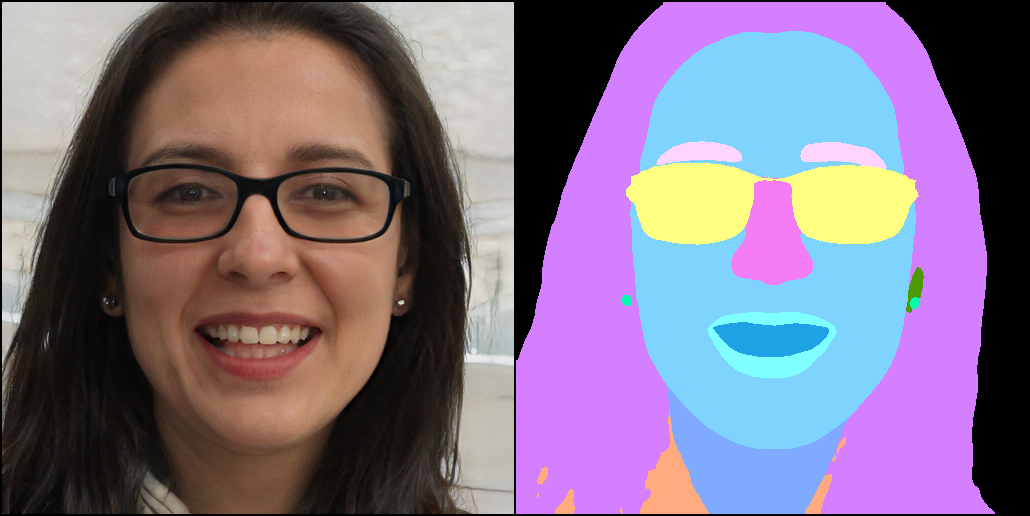

In [37]:
render_tensor([out['image'].clamp(-1, 1), vis_parsing_maps(F.interpolate(out["image_seg"], (512, 512), mode='bilinear'))])

In [42]:
render_tensor(vis_parsing_maps(F.interpolate(out["image_seg"], (512, 512), mode='bilinear'))).save('./debug/seg_org.png')

In [45]:
original_image = out["image_raw"]
original_seg = out["image_seg"]
target_seg = F.interpolate(vis_parsing_maps(read_seg("./debug/seg_modified.png"), inverse=True).float(), (128, 128), mode='nearest').long()
modified_mask = ( original_seg.argmax(dim=1, keepdims=True) != target_seg ).float()

In [47]:
with torch.no_grad():
    delta_w = torch.randn_like(ws[:, :1]).repeat(1, ws.size(1), 1) * 0.01
delta_w = delta_w.requires_grad_(True)
optimizer = torch.optim.Adam([delta_w], lr=0.02, betas=(0.9, 0.999))

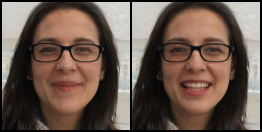

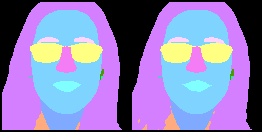

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]


In [52]:
for step in tqdm(range(100)):
    # Step
    optimizer.zero_grad(set_to_none=True)

    # Expand base code
    w_opt = ws + delta_w
    
    planes = encode(G, w_opt, noise_mode='const')
    norm_planes, _, _ = normalize_plane(planes)
    denorm_planes = denormalize_plane(norm_planes, mean, var)
    out = decode(G, w_opt, camera_params, norm_planes, denorm_planes, noise_mode='const')
    
    pred_image = out["image_raw"]
    pred_seg = out["image_seg"]
    
    loss_seg = torch.nn.CrossEntropyLoss()(pred_seg, target_seg.squeeze(1))
    loss_consist = lpips_loss((1 - modified_mask) * original_image, (1 - modified_mask) * pred_image).mean() + \
                    torch.nn.MSELoss()((1 - modified_mask) * original_image, (1 - modified_mask) * pred_image)

    loss = loss_seg + loss_consist

    loss.backward()
    optimizer.step()
    
    clear_output(wait=True)
    display(render_tensor([pred_image.clamp(-1, 1), original_image.clamp(-1, 1)]))
    display(render_tensor([vis_parsing_maps(pred_seg), vis_parsing_maps(target_seg, argmax=False)]))

In [53]:
w_opt = (ws + delta_w).detach().requires_grad_(False)

In [61]:
cam2world_pose = LookAtPoseSampler.sample(5*np.pi/12, 6*np.pi/12, cam_pivot, radius=cam_radius, device=device)
camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

In [62]:
planes = encode(G, ws, noise_mode='const')
norm_planes, _, _ = normalize_plane(planes)
denorm_planes = denormalize_plane(norm_planes, mean, var)
out_org = decode(G, ws, camera_params, norm_planes, denorm_planes, noise_mode='const')

In [63]:
planes = encode(G, w_opt, noise_mode='const')
norm_planes, _, _ = normalize_plane(planes)
denorm_planes = denormalize_plane(norm_planes, mean, var)
out_modified = decode(G, w_opt, camera_params, norm_planes, denorm_planes, noise_mode='const')

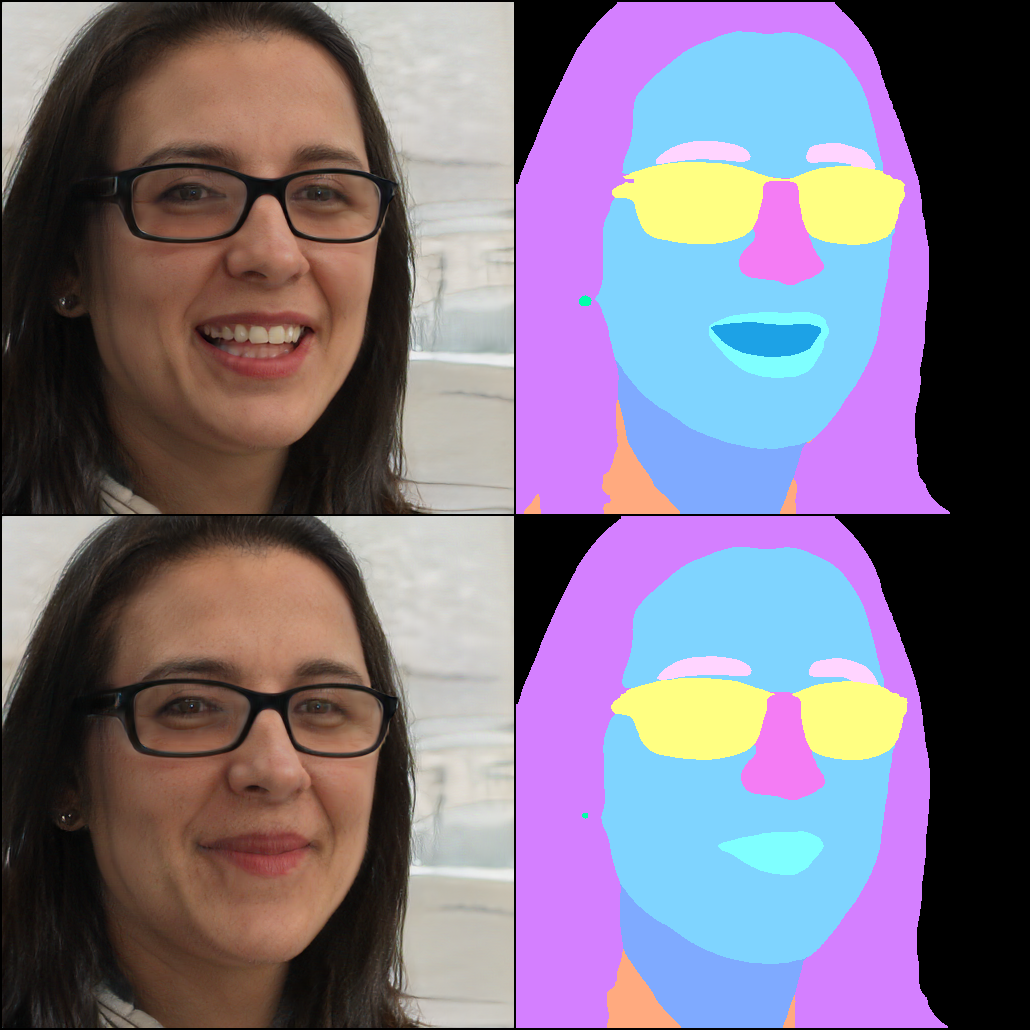

In [64]:
render_tensor([out_org["image"].clamp(-1, 1), vis_parsing_maps(F.interpolate(out_org["image_seg"], (512, 512), mode='bilinear')), 
              out_modified["image"].clamp(-1, 1), vis_parsing_maps(F.interpolate(out_modified["image_seg"], (512, 512), mode='bilinear'))], nrow=2)